In [ ]:
import os
import math
import json
import zipfile

import numpy as np

import torch
import torch.nn as nn

import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import AnchorGenerator

from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

In [ ]:
# https://public.roboflow.com/object-detection/na-mushrooms/1

with zipfile.ZipFile('North American Mushrooms.v1-416x416.coco.zip', 'r') as f:
    f.extractall('.')

In [ ]:
annotations = json.load(open('train/_annotations.coco.json'))
annotations.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [ ]:
class CocoAnnotationCollector:

  def __init__(self, annotations):
    self.id2image = {}
    self.image2info = {}
    self.id2annotations = {}
    self.image_names = []
    self.annotations = annotations

    for info in self.annotations['images']:
      image_name = info['file_name']
      image_id = info['id']

      self.image_names.append(image_name)

      if image_id not in self.id2image:
        self.id2image[image_id] = image_name
        self.image2info[image_name] = {
            'id': image_id,
            'height': info['height'],
            'width': info['width']
        }

    for annot in self.annotations['annotations']:
      image_id = annot['image_id']

      if image_id not in self.id2annotations:
        self.id2annotations[image_id] = [{
            'area': annot['area'],
            'iscrowd': annot['iscrowd'],
            'bbox': annot['bbox']
        }]
      else:
        self.id2annotations[image_id].append({
            'area': annot['area'],
            'iscrowd': annot['iscrowd'],
            'bbox': annot['bbox']
        })

  def get_by_index(self, index):
      image_name = self.image_names[index]
      image_id = self.image2info[image_name]['id']
      return self.id2annotations[image_id]

  def get_by_name(self, name):
    image_id = self.image2info[name]['id']
    return self.id2annotations[image_id]

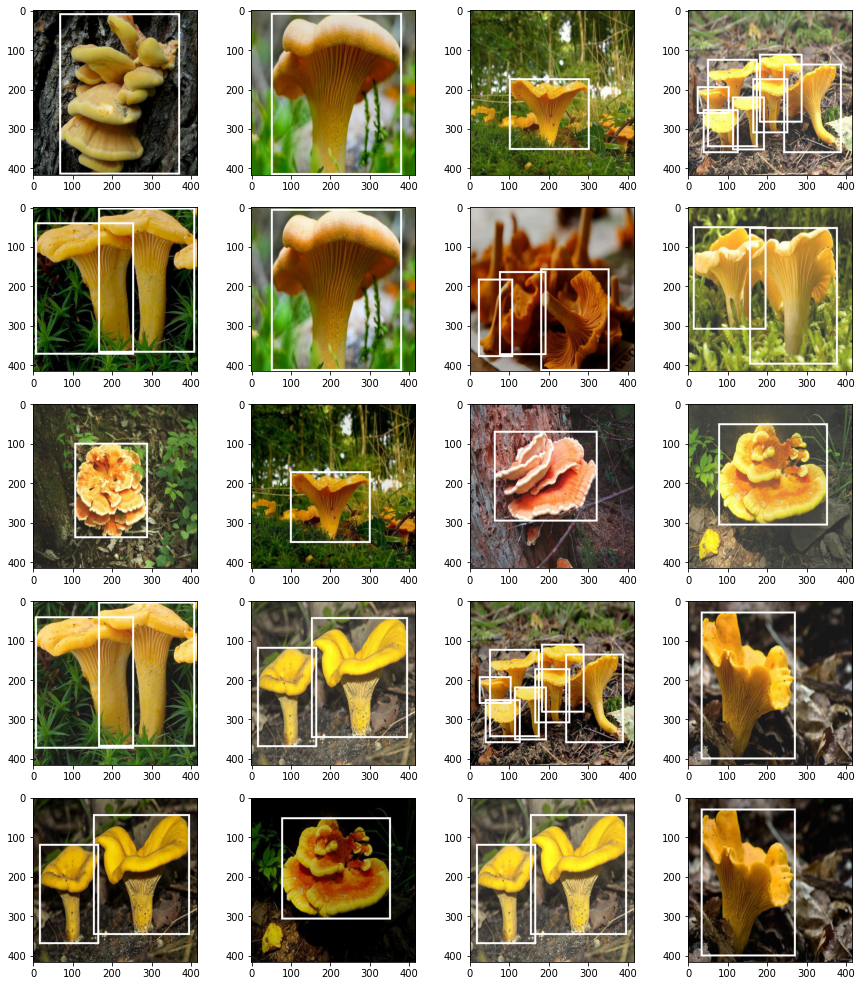

In [ ]:
N_IMAGES = 20
N_COLUMNS = 4
N_ROWS = math.ceil(N_IMAGES / N_COLUMNS)

annot_collector = CocoAnnotationCollector(annotations)

fig, axes = plt.subplots(N_ROWS, N_COLUMNS, figsize=(15, 3.5 * N_ROWS))

for pos, filename in enumerate(os.listdir('train')[:N_IMAGES]):
  if filename.endswith('.jpg'):
    image = Image.open(f'train/{filename}')
    draw = ImageDraw.Draw(image)

    image_annotations = annot_collector.get_by_name(filename)

    for annotation in image_annotations:
      bbox = annotation['bbox']
      draw.rectangle([(bbox[0], bbox[1]), (bbox[0] + bbox[2], bbox[1] + bbox[3])], fill=None, width=5)

    x_pos = pos // N_COLUMNS
    y_pos = pos % N_COLUMNS

    axes[x_pos][y_pos].imshow(image)

In [ ]:
class MushroomDataset(Dataset):

  def __init__(self, path, annotations):
    self.path = path
    self.annotation_collector = CocoAnnotationCollector(annotations)

  def __getitem__(self, index):
    image_name = self.annotation_collector.image_names[index]
    annotations = self.annotation_collector.get_by_name(image_name)

    image = Image.open(f'{self.path}/{image_name}')
    image = np.array(image).transpose(2, 0, 1)
    image = image / image.max()

    t_image = torch.tensor(image, dtype=torch.float32)

    bboxes = []
    areas = []

    for annot in annotations:
      bbox = annot['bbox']
      bboxes.append([bbox[0], bbox[1], 
                     bbox[0] + bbox[2], bbox[1] + bbox[3]])
      areas.append(annot['area'])

    t_bboxes = torch.tensor(bboxes, dtype=torch.float32)
    t_areas = torch.tensor(areas, dtype=torch.float32)
    t_labels = torch.ones((len(annotations),), dtype=torch.int64)
    t_iscrowd = torch.zeros((len(annotations),), dtype=torch.int64)

    target = {
        'boxes': t_bboxes,
        'area': t_areas,
        'labels': t_labels,
        'image_id': torch.tensor([index]),
        'iscrowd': t_iscrowd
    }

    return t_image, target


  def __len__(self):
    return len(self.annotation_collector.image_names)


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_model(num_classes):
  backbone = torchvision.models.mobilenet_v2(pretrained=True).features
  backbone.out_channels = 1280

  anchor_generator = AnchorGenerator(
      sizes=((32, 64, 128, 256),),
      aspect_ratios=((0.5, 0.75, 1.0, 1.5, 2.0),)
  )

  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
      featmap_names=['0'],
      output_size=7,
      sampling_ratio=2
  )
  
  model = torchvision.models.detection.FasterRCNN(
      backbone,
      num_classes=2,
      rpn_anchor_generator=anchor_generator,
      box_roi_pool=roi_pooler
  )

  return model

In [ ]:
model = get_model(num_classes=2)
dataset = MushroomDataset('train', annotations)
train_loader = DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=1e-4)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
print(device)

cuda


In [ ]:
from tqdm import tqdm


def train_epoch(model, loader, optimizer):
  epoch_loss = 0

  for batch in tqdm(loader):
    images, targets = batch
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses.detach().item()

  return epoch_loss / len(loader)

In [ ]:
model.train()

for e in range(10):
  train_loss = train_epoch(model, train_loader, optimizer)
  print(f'epoch: {e + 1}, loss: {train_loss}')

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


epoch: 1, loss: 1.2150049751455134


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


epoch: 2, loss: 0.7591700608080084


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


epoch: 3, loss: 0.5272363749417391


100%|██████████| 11/11 [00:13<00:00,  1.26s/it]


epoch: 4, loss: 0.5212941549041055


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


epoch: 5, loss: 0.5161103443665938


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


epoch: 6, loss: 0.37405411221764306


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


epoch: 7, loss: 0.3236797641624104


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


epoch: 8, loss: 0.24590894173492084


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


epoch: 9, loss: 0.2622826871546832


100%|██████████| 11/11 [00:13<00:00,  1.25s/it]

epoch: 10, loss: 0.3113866936076771


In [ ]:
model.eval()

def predict(model, annot_collector, index, ax=None):
  with torch.no_grad():
    image_name = annot_collector.image_names[index]
    origin_image = Image.open(f'train/{image_name}')
    image = np.array(origin_image).transpose(2, 0, 1)
    image = image / image.max()

    t_image = torch.tensor(image, dtype=torch.float32).to(device)
    predictions = model([t_image])[0]

    box_predictions = predictions['boxes'].detach().cpu().numpy()
    score_predictions = predictions['scores'].detach().cpu().numpy()

    top_indexes = np.where(score_predictions > 0.7)[0]
    # print(top_indexes)

    draw = ImageDraw.Draw(origin_image)

    for i in top_indexes:
      bbox = box_predictions[i]
      draw.rectangle([(bbox[0], bbox[1]), (bbox[2], bbox[3])], fill=None, width=5)

    if ax is None:
      plt.imshow(origin_image)
    else:
      ax.imshow(origin_image)


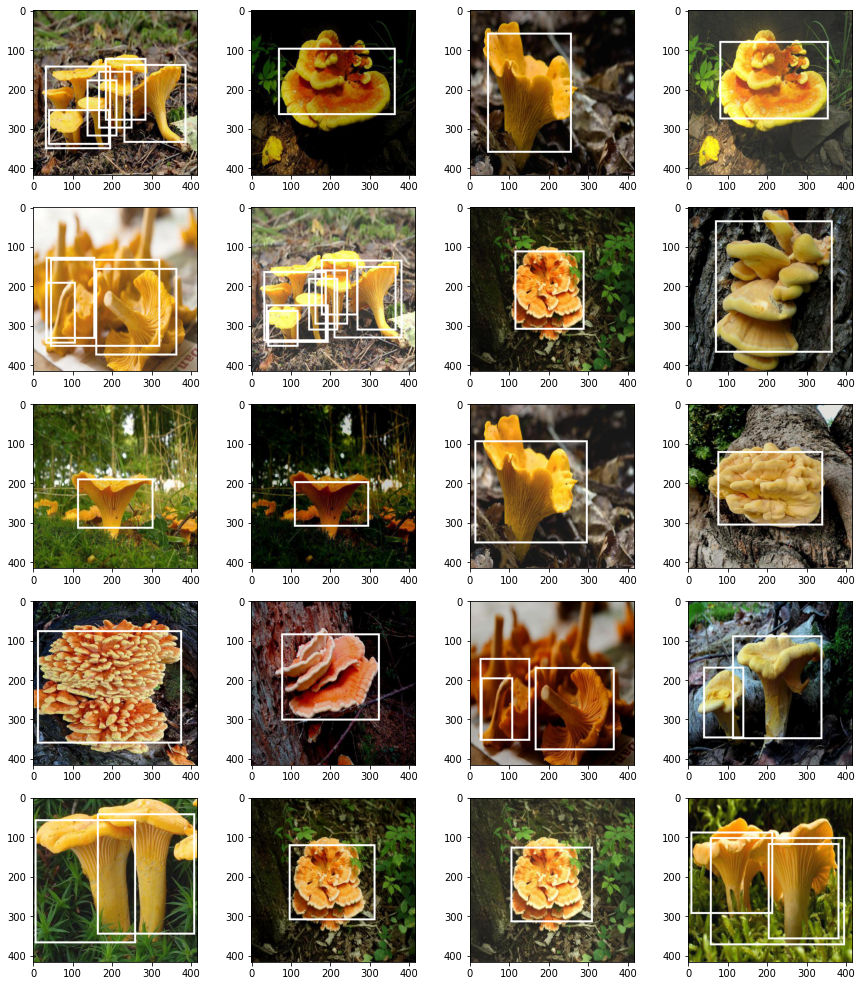

In [ ]:
N_IMAGES = 20
N_COLUMNS = 4
N_ROWS = math.ceil(N_IMAGES / N_COLUMNS)

fig, axes = plt.subplots(N_ROWS, N_COLUMNS, figsize=(15, 3.5 * N_ROWS))

for pos in range(N_IMAGES):
    x_pos = pos // N_COLUMNS
    y_pos = pos % N_COLUMNS
    predict(model, annot_collector, pos, axes[x_pos][y_pos])